# Fastscapelib "user flow kernels" prototype

Benoît Bovy (@benbovy) April 2024

In [1]:
import ctypes
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numba as nb
import numpy as np

import fastscapelib as fs

## User flow kernel (numba) implementation

In [2]:
@dataclass
class JITFlowKernel:
    """A small, convenient callable dataclass that holds the flow kernel
    function (original + jit-compiled C callback) and its metadata.

    """
    func: callable
    c_callback: callable
    var_names: tuple[str]
    output_var_names: tuple[str]
    output_var_indices: tuple[int]

    def __call__(self, node_vars, receivers_vars, var_names):
        self.func(node_vars, receivers_vars, var_names)


def jit_flow_kernel(
    var_names: tuple[str],
    output_var_names: str | tuple[str],
):
    """Decorator for creating a Fastscapelib flow kernel from a Python
    function.

    The decorated function (i.e., "kernel function") is just-in-time
    compiled and then wrapped in a C/C++ callback so that it can be
    executed efficiently while traversing the flow graph.

    The decorated function must have the following signature:

    ``func(nodes_vars, receivers_vars, var_names) -> None``

    With the following passed arguments

    - ``nodes_vars`` : 1-d array of variable values at the current grid (graph)
      node.
    - ``receivers_vars`` : 2-d array of variable values (rows) at each of
      the receiver nodes (columns).
    - ``var_names`` : ordered sequence of variable names that can be used to
      slice or select the arrays above by variable name instead of by integer
      position.

    Parameters
    ----------
    var_names : tuple
        Names of all input and output variable used by the flow kernel. Each
        variable corresponds to a scalar field computed at the grid (graph)
        nodes. Variable values passed as arrays to the kernel function will
        be in the same order than this sequence of names. A maximum of 15
        user-defined variables is allowed.
    output_var_names : tuple
        Names of all output variables. Each name given here must be present
        also in ``var_names``. The user kernel function usually sets or
        updates the values of those variables via the ``nodes_vars`` argument.
        Only those variables will be updated when applying the kernel over
        the flow graph (updates on other variables within the kernel will be
        ignored).
    
    """
    if len(var_names) > 15:
        raise ValueError(
            f"Maximum 15 variables allowed ({len(var_names)} variable names given)"
        )
    
    if isinstance(output_var_names, str):
        output_var_names = (output_var_names,)

    output_var_indices = []
    for oname in output_var_names:
        if oname not in var_names:
            raise ValueError(f"output variable {oname!r} not in var_names")
        output_var_indices.append(var_names.index(oname))

    def decorator(func):
        jitted_func = nb.njit(func)
    
        signature = nb.types.void(
            nb.types.intc,
            nb.types.CPointer(nb.types.double),
            nb.types.CPointer(nb.types.double),
        )
    
        @nb.cfunc(signature)
        def wrapped(nb_receivers, nodes_vars_ptr, receivers_vars_ptr):
            nodes_vars = nb.carray(nodes_vars_ptr, 1)
            receivers_vars = nb.carray(receivers_vars_ptr, (len(var_names), nb_receivers))
            
            jitted_func(nodes_vars, receivers_vars, var_names)
    
        return JITFlowKernel(
            func=func,
            c_callback=wrapped,
            var_names=tuple(var_names),
            output_var_names=tuple(output_var_names),
            output_var_indices=tuple(output_var_indices),
        )

    return decorator

## Example of decorated (jitted) flow kernel function

In [3]:
@jit_flow_kernel(
    var_names=("elevation", "erosion"),
    output_var_names="erosion",
)
def test_kernel(nodes_vars, receivers_vars, var_names):
    elevation_ = var_names.index("elevation")
    erosion_ = var_names.index("erosion")

    diff_elevation = nodes_vars[elevation_] - receivers_vars[elevation_].min()
    nodes_vars[erosion_] = diff_elevation / 2.0


## Emulate kernel function execution from C using ctypes

In [4]:
def get_ptr(array):
    return array.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

# create and fill test data
# (we set the max number of fields and the max number of
# flow graph node receivers both to 20)

data_node = np.zeros(20, dtype=np.double)
# elevation at current node
data_node[0] = 10.

nb_receivers = 3

data_receivers = np.empty((20, 20), dtype=np.double)
# elevation at each of the 3 receivers
data_receivers[0][0:3] = [7., 8., 6.]

# erosion has not been computed yet (should be zero)
print(data_node[1])

# call the C callback
test_kernel.c_callback.ctypes(
    nb_receivers, get_ptr(data_node), get_ptr(data_receivers)
)

# check that erosion has been assigned with the right value
# (using the test kernel and data above, this should be 2.0)
print(data_node[1])

0.0
2.0


In [5]:
%timeit test_kernel.c_callback.ctypes(nb_receivers, get_ptr(data_node), get_ptr(data_receivers))

6.06 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Applying the flow kernel over the flow graph

Traverse the flow graph and call the kernel function (C callback) from within a Numba no-python jitted function.

In [6]:
@nb.njit
def _apply_kernel(
    kernel_cfunc,
    var_names,
    output_var_indices,
    variables,
    dfs_indices,
    receivers_count,
    receivers,
):
    # init (temporary) kernel data
    # (max. 20 variables, max. 20 node receivers)
    data_node = np.zeros(20, dtype=np.double)
    data_receivers = np.empty((20, 20), dtype=np.double)

    # traverse flow graph in depth-first order
    for inode in dfs_indices:
        nb_receivers = receivers_count[inode]
        
        # copy variable values into kernel data
        for v in range(len(var_names)):
            data_node[v] = variables[v][inode]
            for r in range(nb_receivers):
                irec = receivers[inode][r]
                data_receivers[v][r] = variables[v][irec]
    
        # execute C callback
        kernel_cfunc(nb.int32(nb_receivers), data_node.ctypes, data_receivers.ctypes)
    
        # copy output variable values from kernel data
        for ov in output_var_indices:
            variables[ov][inode] = data_node[ov]


def apply_kernel(
    flow_graph: fs.FlowGraph,
    kernel: JITFlowKernel,
    variables: dict[str, np.ndarray]
):
    if tuple(variables) != kernel.var_names:
        raise ValueError("variables and kernel variable names don't match")

    flow_graph_impl = flow_graph.impl()

    _apply_kernel(
        kernel.c_callback.ctypes,
        kernel.var_names,
        kernel.output_var_indices,
        nb.typed.List([arr.ravel() for arr in variables.values()]),
        flow_graph_impl.dfs_indices,
        flow_graph_impl.receivers_count,
        flow_graph_impl.receivers,
    )


Example on a small raster grid with the kernel created above:

In [7]:
grid = fs.RasterGrid([5, 5], [100, 100], fs.NodeStatus.FIXED_VALUE)
flow_graph = fs.FlowGraph(grid, [fs.PFloodSinkResolver(), fs.MultiFlowRouter()])

rng = np.random.Generator(np.random.PCG64(1234))

elevation = rng.uniform(0, 5, size=grid.shape)
erosion = np.empty_like(elevation)

filled_elevation = flow_graph.update_routes(elevation);

In [8]:
apply_kernel(
    flow_graph, test_kernel, {"elevation": filled_elevation, "erosion": erosion}
)

In [9]:
erosion

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.30918765, 0.19191909, 1.75596705, 0.        ],
       [0.        , 1.22944894, 1.72888778, 1.72922872, 0.        ],
       [0.        , 1.6890476 , 0.12671868, 0.27982218, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [10]:
filled_elevation

array([[4.88349883, 1.90097868, 4.61623117, 1.30846212, 1.59548529],
       [0.59045616, 1.20883147, 1.59266964, 4.82039623, 1.31824902],
       [2.20503061, 3.04935405, 4.31810648, 4.31878835, 3.37440657],
       [3.29937174, 3.67878849, 1.11376829, 0.86033092, 4.35207486],
       [0.30069329, 3.41844455, 3.3561901 , 3.05508991, 0.30068656]])

In [11]:
%timeit apply_kernel(flow_graph, test_kernel, {"elevation": filled_elevation, "erosion": erosion})

87.6 µs ± 687 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Benchmarks

Compare a basic version of the SPL eroder implemented in:

- pure Python
- Numba-jitted
- Numba flow kernels
- `fastscapelib.eroders.SPLEroder` Python bindings

### Reference simulation (Mountain)

See https://fastscapelib.readthedocs.io/en/latest/examples/mountain_py.html for reference

In [50]:
grid = fs.RasterGrid.from_length([201, 301], [5e4, 7.5e4], fs.NodeStatus.FIXED_VALUE)
flow_graph = fs.FlowGraph(grid, [fs.SingleFlowRouter(), fs.MSTSinkResolver()])

rng = np.random.Generator(np.random.PCG64(1234))

init_elevation = rng.uniform(0, 1, size=grid.shape)
drainage_area = np.empty_like(elevation)

uplift_rate = np.full_like(elevation, 1e-3)
uplift_rate[[0, -1], :] = 0.
uplift_rate[:, [0, -1]] = 0.

dt = 2e4
nsteps = 50

k_coef = 2e-4
area_exp = 0.4
slope_exp = 1

In [51]:
def run_simulation(spl_func):
    elevation = init_elevation.copy()

    for step in range(nsteps):
        # uplift (no uplift at fixed elevation boundaries)
        uplifted_elevation = elevation + dt * uplift_rate
        
        # flow routing
        filled_elevation = flow_graph.update_routes(uplifted_elevation)
        
        # flow accumulation (drainage area)
        flow_graph.accumulate(drainage_area, 1.0)
        
        # apply channel erosion (SPL)
        spl_erosion = spl_func(uplifted_elevation, drainage_area, dt)
        
        # update topography
        elevation = uplifted_elevation - spl_erosion

    return elevation.copy()


### Pure-python

In [58]:
flow_graph_impl = flow_graph.impl()
erosion_py = np.empty_like(init_elevation)


def _basic_spl(
    elevation,
    drainage_area,
    dt,
    receivers,
    receivers_count,
    receivers_distance,
    receivers_weight,
    dfs_indices,
    erosion,
):
    erosion.fill(0.)

    elevation_flat = elevation.ravel()
    erosion_flat = erosion.ravel()
    drainage_area_flat = drainage_area.ravel()

    for inode in dfs_indices:
        inode_elevation = elevation_flat[inode]
        r_count = receivers_count[inode]
        
        if nb_receivers == 1 and receivers[inode][0] == inode:
            continue

        elevation_flooded = np.finfo(np.double).max

        for r in range(r_count):
            irec = receivers[inode, r]
            irec_elevation_next = elevation_flat[irec] - erosion_flat[irec]

            if irec_elevation_next < elevation_flooded:
                elevation_flooded = irec_elevation_next

        if inode_elevation <= elevation_flooded:
            continue

        eq_num = inode_elevation
        eq_den = 1.0

        for r in range(r_count):
            irec = receivers[inode, r]
            irec_elevation = elevation_flat[irec]
            irec_elevation_next = irec_elevation - erosion_flat[irec]

            if irec_elevation > inode_elevation:
                continue

            irec_weight = receivers_weight[inode, r]
            irec_distance = receivers_distance[inode, r]

            factor = k_coef * dt * np.power(drainage_area_flat[inode] * irec_weight, area_exp)
            factor /= irec_distance
            eq_num += factor * irec_elevation_next
            eq_den += factor

        inode_elevation_updated = eq_num / eq_den

        if inode_elevation_updated < elevation_flooded:
            inode_elevation_updated = elevation_flooded + np.finfo(np.double).tiny

        erosion_flat[inode] = inode_elevation - inode_elevation_updated


def basic_spl_py(elevation, drainage_area, dt):
    receivers = flow_graph_impl.receivers
    receivers_count = flow_graph_impl.receivers_count
    receivers_distance = flow_graph_impl.receivers_distance
    receivers_weight = flow_graph_impl.receivers_weight
    dfs_indices = flow_graph_impl.dfs_indices

    _basic_spl(
        elevation,
        drainage_area,
        dt,
        receivers,
        receivers_count,
        receivers_distance,
        receivers_weight,
        dfs_indices,
        erosion_py,
    )

    return erosion_py

### Numba-jitted

In [59]:
erosion_numba = np.empty_like(init_elevation)

_jitted_basic_spl = nb.njit(_basic_spl)


def basic_spl_numba(elevation, drainage_area, dt):
    receivers = flow_graph_impl.receivers
    receivers_count = flow_graph_impl.receivers_count
    receivers_distance = flow_graph_impl.receivers_distance
    receivers_weight = flow_graph_impl.receivers_weight
    dfs_indices = flow_graph_impl.dfs_indices

    _jitted_basic_spl(
        elevation,
        drainage_area,
        dt,
        receivers,
        receivers_count,
        receivers_distance,
        receivers_weight,
        dfs_indices,
        erosion_numba,
    )

    return erosion_numba


### Fastscapelib Python bindings

In [60]:
spl_eroder = fs.SPLEroder(
    flow_graph,
    k_coef=k_coef,
    area_exp=area_exp,
    slope_exp=slope_exp,
    tolerance=1e-5,
)

def basic_spl_fastscapelib(elevation, drainage_area, dt):
    return spl_eroder.erode(elevation, drainage_area, dt)

### Benchmark Results

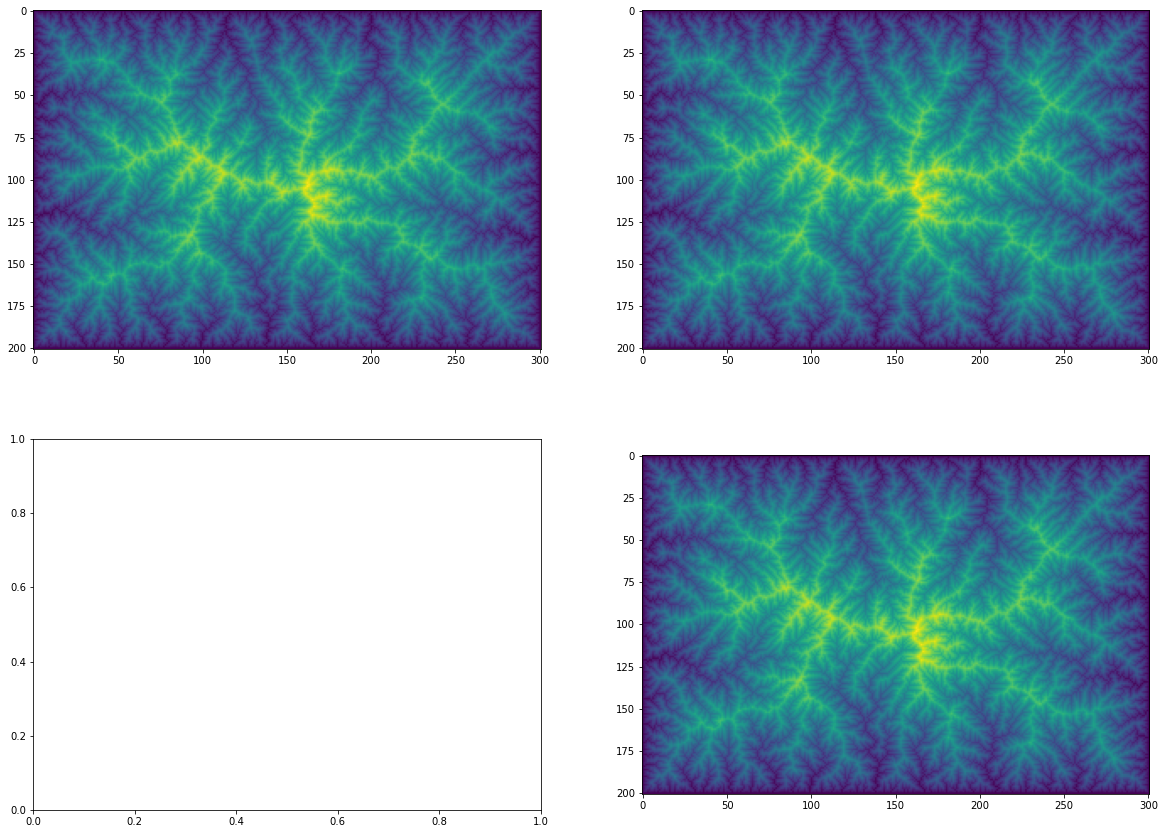

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

axes[0][0].imshow(run_simulation(basic_spl_py))
axes[0][1].imshow(run_simulation(basic_spl_numba))
axes[1][1].imshow(run_simulation(basic_spl_fastscapelib));

In [64]:
%timeit run_simulation(basic_spl_py)

14.9 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [65]:
%timeit run_simulation(basic_spl_numba)

643 ms ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit run_simulation(basic_spl_fastscapelib)

657 ms ± 4.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
